In [1]:
#import packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm 
import scipy.stats as stats
from stargazer.stargazer import Stargazer, LineLocation
import nltk
from nltk.corpus import stopwords
import lemmy

In [2]:
dataset = pd.read_csv("cleandata.csv",index_col="Unnamed: 0")


In [3]:
dateend = datetime(2021,2,4)
dstart = datetime(2020,2,26)
linde_date = datetime.strptime("2020-08-26", "%Y-%m-%d")

In [4]:
dataset['datetime'] = [datetime.strptime(d, "%Y-%m-%d") for d in dataset['datetime']]
dataset['date_clean'] = [datetime.strptime(str(d), "%Y-%m-%d") for d in dataset['date_clean']]
dataset = dataset[dataset['datetime'] > dstart]

In [5]:
dataset = dataset.reset_index(drop = True)

In [6]:
plt.rcParams.update({'font.size': 12})

# I begin by making some plots for the paper

In [7]:
sum(dataset['n_women'] >= 3)

217

In [8]:
dataset['n_women'].max()

16.0

In [9]:
dataset = dataset[dataset['n_women'] < 3]

In [10]:
n_women_set = dataset.groupby('date_clean').agg({'n_women': ['mean','sum']})
n_women_set = n_women_set['n_women'] 

In [11]:
dates = n_women_set.index
#dates = [datetime.strptime(d, "%Y-%m-%d") for d in list(dates)]
n_women_set['dates'] = dates
n_women_set = n_women_set.reset_index(drop = True)
dateend = datetime(2020,9,1)
dstart = datetime(2020,8,20)

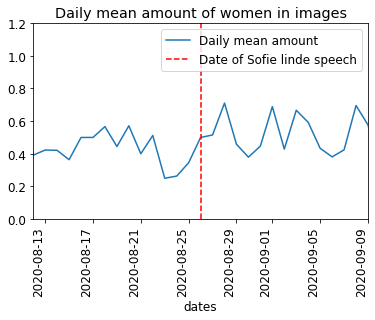

In [12]:
n_women_set.plot(y = "mean",x = "dates", label = "Daily mean amount")
plt.xlim(dstart,dateend)
plt.ylim(0,1.5)
plt.xticks(rotation = 90)
plt.title("Daily mean amount of women in images")
plt.axvline(x = linde_date, color = 'r', label = 'Date of Sofie linde speech', linestyle = "--") 
plt.xlim(linde_date - timedelta(14),linde_date + timedelta(14))
plt.ylim(0,1.2)
plt.legend()

#plt.savefig("plots\\daily_amount_14_nwomen.png")

plt.show()

In [13]:
plt.rcParams.update({'font.size': 22})

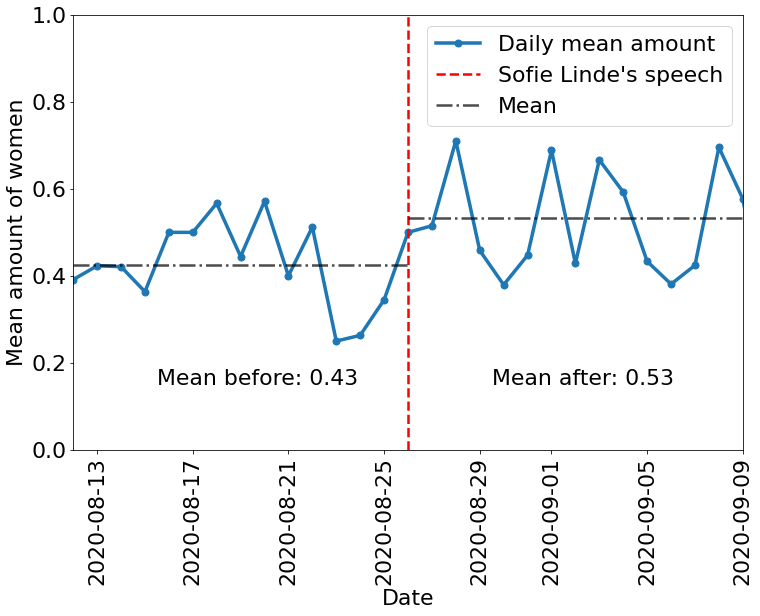

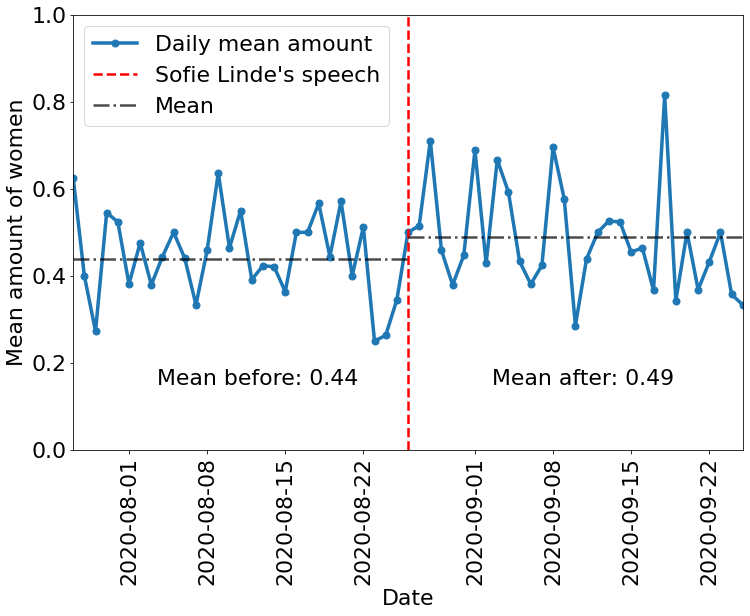

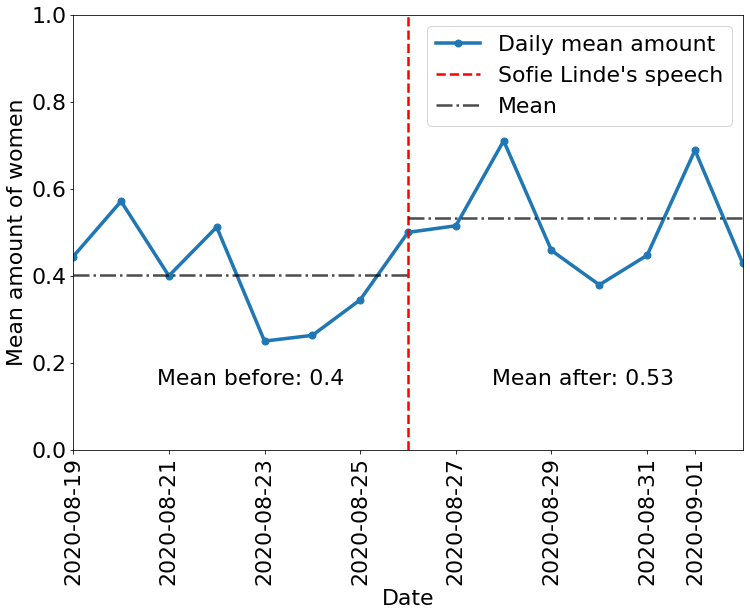

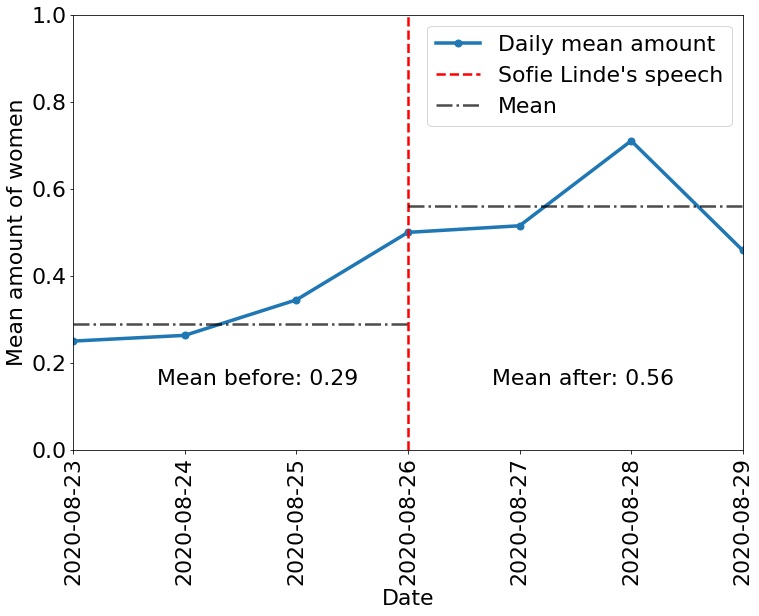

In [14]:
for i in [14,30,7,3]:
    thirty_days = dataset[abs(dataset['days_till_linde']) <=i]
    before = thirty_days.loc[thirty_days['treatment'] == 0,'n_women'].mean()
    after = thirty_days.loc[thirty_days['treatment'] == 1,'n_women'].mean()
    dateend = linde_date + timedelta(i)
    dstart = linde_date - timedelta(i)

    #n_women_set.plot(y = "mean",x = "dates", label = "Daily mean amount")
    plt.figure(figsize=(12,8))
    plt.plot(n_women_set['dates'],n_women_set['mean'], label = "Daily mean amount", marker= ".", markersize=14, linewidth=3.5)
    #plt.plot()
    plt.xlim(dstart,dateend)
    plt.ylim(0,1.5)
    plt.xticks(rotation = 90)
    #plt.title("Daily mean amount of women in images")
    plt.axvline(x = linde_date, color = 'r', label = 'Sofie Linde\'s speech', linestyle = "--", linewidth=2.5) 
    plt.axhline(before, xmax = 0.5, color = 'black', label = 'Mean', linestyle = "-.", alpha = 0.7, linewidth=2.5) 
    plt.axhline(after, xmin = 0.5, color = 'black',  linestyle = "-.", alpha = 0.7, linewidth=2.5) 
    plt.annotate(str("Mean before: " + str(round(before,2))), xy =  (dstart + timedelta(i/4),0.15))
    plt.annotate(str("Mean after: " + str(round(after,2))), xy =  (dateend - timedelta((i/4)*3),0.15))

    plt.xlim(linde_date - timedelta(i),linde_date + timedelta(i))
    plt.ylim(0,1)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Mean amount of women")
    name = "plots\\daily_amount_" + str(i) +"_nwomen.png"
    plt.savefig(name,bbox_inches = "tight")
    plt.show()

Remove all outliers based on 3 or more women


In [15]:
after

0.5609756097560976

# I then do the regressions with amount as y (OLS instead of logistic because y is continous) 

In [16]:
y = "n_women"

In [17]:
model1 = sm.ols(formula= y + " ~ treatment" , data = dataset).fit() 
model2 = sm.ols(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=30]).fit() 
model3 = sm.ols(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=14]).fit() 
model4 = sm.ols(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=7]).fit() 
model5 = sm.ols(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=3]).fit() 


stargazer = Stargazer([model1,model2,model3,model4,model5])
stargazer.title('Baseline models')
stargazer

## Looking at all the controlls for all the periods

In [18]:
#dataset[['user','sex']]

In [19]:
#dataset['sex2'] = [1 if dataset.loc[n,'sex'] == "f" else 0 for n in range(len(dataset['days_till_linde']))]

In [20]:
day = 14

In [21]:
model1 = sm.ols(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.ols(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.ols(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.ols(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.ols(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.ols(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

#superusers and tenpersent
model7 = sm.ols(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.ols(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model9 = sm.ols(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model10 = sm.ols(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3,model4,model5,model6, model7,model8,model9,model10])
stargazer.title('Heterogenous effectss')
stargazer

In [22]:
dataset.reset_index(inplace=True)

In [23]:
dataset['days_till_linde_no0'] = [abs(dataset.loc[n,'days_till_linde']) if dataset.loc[n,'days_till_linde'] < 0 else 0 for n in range(len(dataset['days_till_linde']))]

In [24]:
dataset['days_till_linde_no0'] 

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
10194    160.0
10195    160.0
10196    161.0
10197    165.0
10198    169.0
Name: days_till_linde_no0, Length: 10199, dtype: float64

In [25]:
model7 = sm.ols(formula= y + " ~ treatment +days_till_linde" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.ols(formula= y + " ~ treatment* days_till_linde" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

stargazer = Stargazer([model7,model8])
stargazer.title('Heterogenous effectss')
stargazer

In [26]:
day = 3

In [27]:
model1 = sm.ols(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.ols(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.ols(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.ols(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.ols(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.ols(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

#superusers and tenpersent
model7 = sm.ols(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.ols(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model9 = sm.ols(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model10 = sm.ols(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3,model4,model5,model6, model7,model8,model9,model10])
stargazer.title('Heterogenous effectss')
stargazer

In [28]:
day = 7

In [29]:
model1 = sm.ols(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.ols(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.ols(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.ols(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.ols(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.ols(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

#superusers and tenpersent
model7 = sm.ols(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.ols(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model9 = sm.ols(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model10 = sm.ols(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3,model4,model5,model6, model7,model8,model9,model10])
stargazer.title('Heterogenous effectss')
stargazer

In [30]:
day = 30

In [31]:
model1 = sm.ols(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.ols(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.ols(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.ols(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.ols(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.ols(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

#superusers and tenpersent
model7 = sm.ols(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.ols(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model9 = sm.ols(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model10 = sm.ols(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3,model4,model5,model6, model7,model8,model9,model10])
stargazer.title('Heterogenous effectss')
stargazer

# Placebo test
    14- days

In [32]:
param = []
p = []
se = []
days =[]
for i in range(-14, 15):
    before = dataset['datetime'] < linde_date + timedelta(i)
    after  = dataset['datetime'] >=  linde_date + timedelta(i)
    
    dataset.loc[before,'treatment_placebo'] = 0
    dataset.loc[after,'treatment_placebo'] = 1
    
    model1 = sm.ols(formula= y + " ~ treatment_placebo" , data = dataset[abs(dataset['days_till_linde']) <=14]).fit()
    param.append(model1.params[1])
    p.append(model1.pvalues[1])
    se.append(model1.HC0_se[1])
    days.append(linde_date + timedelta(i))
    #stargazer = Stargazer([model1])


In [33]:
se = [i * 1.96 for i in se]

In [34]:
days

[datetime.datetime(2020, 8, 12, 0, 0),
 datetime.datetime(2020, 8, 13, 0, 0),
 datetime.datetime(2020, 8, 14, 0, 0),
 datetime.datetime(2020, 8, 15, 0, 0),
 datetime.datetime(2020, 8, 16, 0, 0),
 datetime.datetime(2020, 8, 17, 0, 0),
 datetime.datetime(2020, 8, 18, 0, 0),
 datetime.datetime(2020, 8, 19, 0, 0),
 datetime.datetime(2020, 8, 20, 0, 0),
 datetime.datetime(2020, 8, 21, 0, 0),
 datetime.datetime(2020, 8, 22, 0, 0),
 datetime.datetime(2020, 8, 23, 0, 0),
 datetime.datetime(2020, 8, 24, 0, 0),
 datetime.datetime(2020, 8, 25, 0, 0),
 datetime.datetime(2020, 8, 26, 0, 0),
 datetime.datetime(2020, 8, 27, 0, 0),
 datetime.datetime(2020, 8, 28, 0, 0),
 datetime.datetime(2020, 8, 29, 0, 0),
 datetime.datetime(2020, 8, 30, 0, 0),
 datetime.datetime(2020, 8, 31, 0, 0),
 datetime.datetime(2020, 9, 1, 0, 0),
 datetime.datetime(2020, 9, 2, 0, 0),
 datetime.datetime(2020, 9, 3, 0, 0),
 datetime.datetime(2020, 9, 4, 0, 0),
 datetime.datetime(2020, 9, 5, 0, 0),
 datetime.datetime(2020, 9, 6,

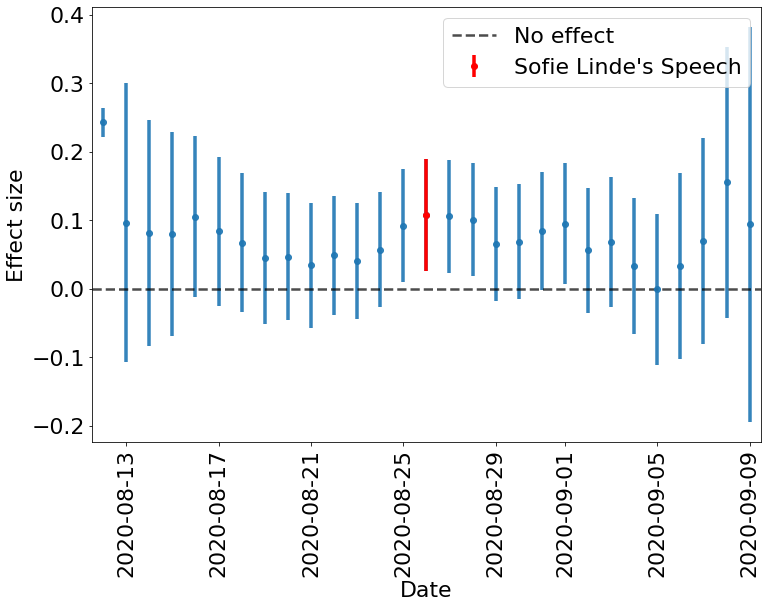

In [35]:
plt.figure(figsize=(12,8))

#plt.scatter(days, param,s=50,linestyle = "--")
plt.errorbar(days, param, yerr=se, fmt="o", linewidth=3.5, alpha = 0.9)
plt.axhline(0, color = 'black', label = "No effect", linestyle = "--", alpha = 0.7, linewidth=2.5) 
#plt.scatter(days[14], param[14],s=50,linestyle = "--", color = "red", alpha = 1)
plt.errorbar(days[14], param[14], yerr = se[14], fmt="o", linewidth=3.5, alpha = 1, color = "red", label = "Sofie Linde's Speech")
#plt.axvline(linde_date, color = 'red', label = "Sofie Linde's Speech", linestyle = "--", alpha = 0.5, linewidth=2.5) 
plt.legend()
plt.xticks(rotation = 90)
#plt.title("Placeboplot for effect of speech")
plt.xlim(linde_date + timedelta(-14.5), linde_date + timedelta(14.5))
plt.ylabel("Effect size")
plt.xlabel("Date")
plt.savefig("plots\\placeboplot.png",bbox_inches = "tight")


In [36]:
before

0        False
1        False
2        False
3        False
4        False
         ...  
10194     True
10195     True
10196     True
10197     True
10198     True
Name: datetime, Length: 10199, dtype: bool

# Working with the 6th of september as treatment 

In [37]:
dateend = datetime(2021,2,4)
dstart = datetime(2020,2,26)
linde_date = datetime.strptime("2020-09-06", "%Y-%m-%d")

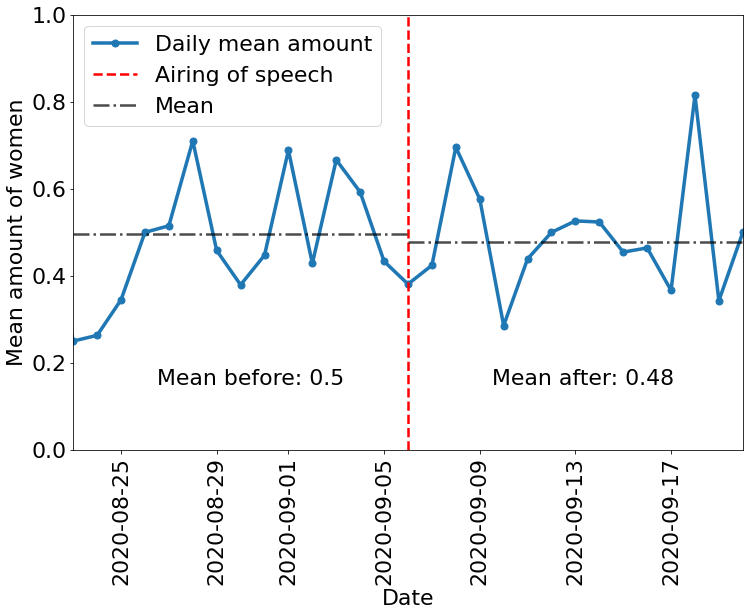

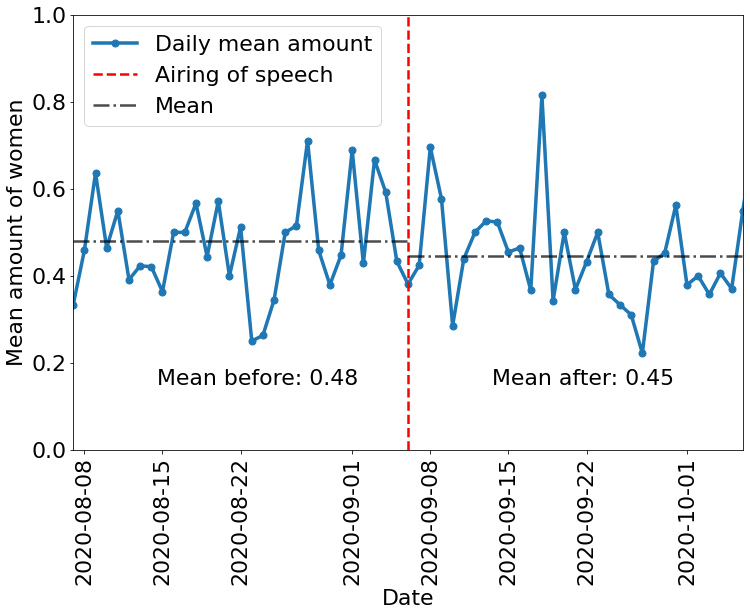

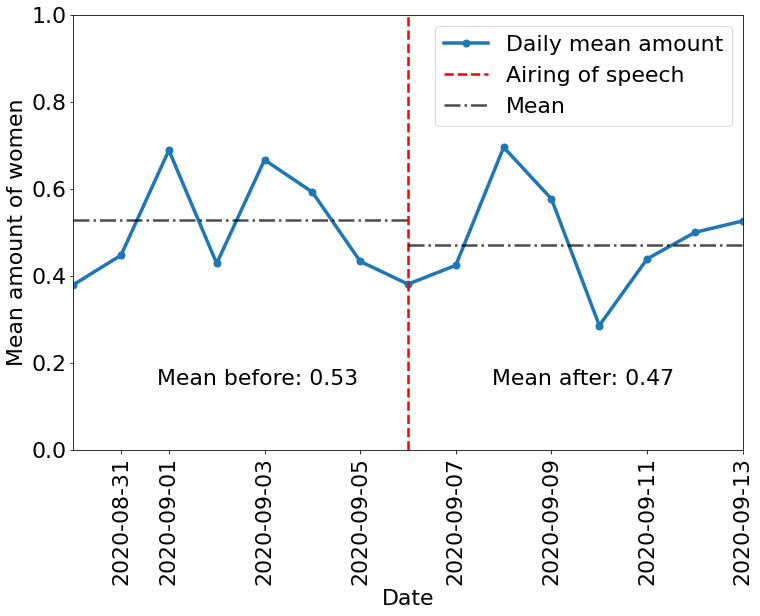

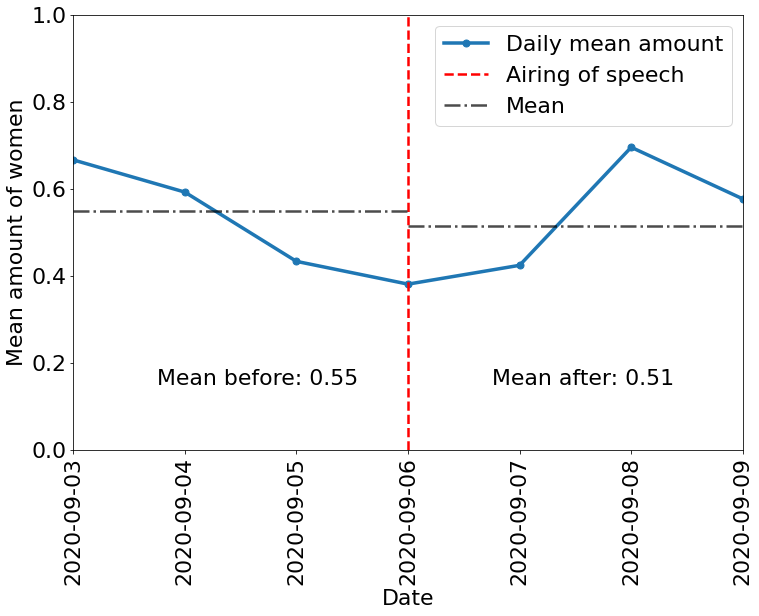

In [38]:
plt.rcParams.update({'font.size': 22})
for i in [14,30,7,3]:
    thirty_days = dataset[abs(dataset['days_till_linde_06']) <=i]
    before = thirty_days.loc[thirty_days['treatment_06'] == 0,'n_women'].mean()
    after = thirty_days.loc[thirty_days['treatment_06'] == 1,'n_women'].mean()
    dateend = linde_date + timedelta(i)
    dstart = linde_date - timedelta(i)

    #n_women_set.plot(y = "mean",x = "dates", label = "Daily mean amount")
    plt.figure(figsize=(12,8))
    plt.plot(n_women_set['dates'],n_women_set['mean'], label = "Daily mean amount", marker= ".", markersize=14, linewidth=3.5)
    #plt.plot()
    plt.xlim(dstart,dateend)
    plt.ylim(0,1.5)
    plt.xticks(rotation = 90)
    #plt.title("Daily mean amount of women in images")
    plt.axvline(x = linde_date, color = 'r', label = 'Airing of speech', linestyle = "--", linewidth=2.5) 
    plt.axhline(before, xmax = 0.5, color = 'black', label = 'Mean', linestyle = "-.", alpha = 0.7, linewidth=2.5) 
    plt.axhline(after, xmin = 0.5, color = 'black',  linestyle = "-.", alpha = 0.7, linewidth=2.5) 
    plt.annotate(str("Mean before: " + str(round(before,2))), xy =  (dstart + timedelta(i/4),0.15))
    plt.annotate(str("Mean after: " + str(round(after,2))), xy =  (dateend - timedelta((i/4)*3),0.15))

    plt.xlim(linde_date - timedelta(i),linde_date + timedelta(i))
    plt.ylim(0,1)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Mean amount of women")
    name = "plots\\daily_amount_28_" + str(i) +"_nwomen.png"
    plt.savefig(name,bbox_inches = "tight")
    plt.show()

In [39]:
y = "n_women"

In [40]:
model1 = sm.ols(formula= y + " ~ treatment_06" , data = dataset).fit() 
model2 = sm.ols(formula= y + " ~ treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=30]).fit() 
model3 = sm.ols(formula= y + " ~ treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=14]).fit() 
model4 = sm.ols(formula= y + " ~ treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=7]).fit() 
model5 = sm.ols(formula= y + " ~ treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=3]).fit() 


stargazer = Stargazer([model1,model2,model3,model4,model5])
stargazer.title('Baseline models')
stargazer

In [41]:
model7 = sm.ols(formula= y + " ~ treatment_06 +days_till_linde_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
model8 = sm.ols(formula= y + " ~ treatment_06 * days_till_linde_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 

stargazer = Stargazer([model7,model8])
stargazer.title('Heterogenous effectss')
stargazer

In [42]:
model1 = sm.ols(formula= y + " ~ treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
model2 = sm.ols(formula= y + " ~ sex +treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
model3 = sm.ols(formula= y + " ~ bloc +  treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
model4 = sm.ols(formula= y + " ~ sex + bloc +  treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
model5 = sm.ols(formula= y + " ~ sex *treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
model6 = sm.ols(formula= y + " ~ bloc * treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 

#superusers and tenpersent
model7 = sm.ols(formula= y + " ~ superuser +treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
model8 = sm.ols(formula= y + " ~ superuser * treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
model9 = sm.ols(formula= y + " ~ tenpercent +treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
model10 = sm.ols(formula= y + " ~ tenpercent * treatment_06" , data = dataset[abs(dataset['days_till_linde_06']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3,model4,model5,model6, model7,model8,model9,model10])
stargazer.title('Heterogenous effectss')
stargazer